In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
from HelperFunctions import timestmphm2sec
from PtOccupancyFunctions import *
from FindDataFunctions import *

In [155]:
def getPersons(path):
    system_size = 10000
    makePeriodic = lambda x: x if x < system_size/2 else system_size - x
    columns = ["first_act_x", "first_act_y", "last_act_x", "last_act_y"]
    df = pd.read_csv(path, sep=";").loc[:,columns]
    diffX = np.abs(df["last_act_x"] - df["first_act_x"])
    diffX = diffX.apply(makePeriodic)
    diffY = np.abs(df["last_act_y"] - df["first_act_y"])
    diffY = diffY.apply(makePeriodic)
    df["mean_dist"] = np.sqrt(diffX**2 + diffY**2)
    return df

In [191]:
path = "/home/helge/Applications/matsim/matsim_results/4DrtCap/OwnIntermodalAccEgr/OptDrtCount/WithServability/oneDrtFleet/bim_diag_30min/200/ITERS/it.0/"
path = "/home/helge/Applications/matsim/matsim_results_ssd/NonPeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/WithServability/oneDrtFleet/bim_15min_diag/200/ITERS/it.0/"
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/CILocalEllipses/100000reqs/3000dist/1500drt/3000dcut/3000l/bimodal/"
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/CILocalEllipsesConvCrit500drt/100000reqs/3000dist/500drt/1700dcut/1000l/bimodal/"
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/CILocalEllipses0.77DCut1500Drt/300000reqs/3000dist/1500drt/2310dcut/3000l/bimodal/"
itpath = os.path.join(path , "ITERS/it.0/")
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/SteffenDrt/drt300/ITERS/it.0/"
pathDetour = itpath + "0.drt_detours_drt.csv"
pathTrips = itpath + "0.drt_trips_drt.csv"
pathOccs = itpath + "0.drt_occupancy_time_profiles_drt.txt"
detour_df = pd.read_csv(pathDetour, delimiter=";")
trip_df = pd.read_csv(pathTrips, delimiter=";")
df_persons = getPersons(os.path.join(path, "output_persons.csv.gz"))
req_mean_dist = df_persons["mean_dist"].mean()
occ_df = pd.read_csv(pathOccs, delimiter="\t")
occ_df["time"] = occ_df["time"].apply(timestmphm2sec)
av_drt_occ, standing_frac = getDrtOccupandyAndStandingFrac({"drt_occupancy": pathOccs}, False, True)
av_drt_occ_non_idle, _ = getDrtOccupandyAndStandingFrac({"drt_occupancy": pathOccs}, False)
av_drt_detour = detour_df["distanceDetour"].mean()

v_drt = 30/3.6
timescale = req_mean_dist/v_drt
detour_df["time"] /= timescale
detour_df["unsharedTime"] /= timescale
trip_df["waitTime"] /= timescale
beta = 900/timescale

In [192]:
print("av_detour: ", av_drt_detour)
print("av_occ: ", av_drt_occ)
print("eta: ", av_drt_occ_non_idle/av_drt_detour)

av_detour:  2.174670549290136
av_occ:  2.801395222222222
eta:  1.7661544615264324


6.668134604757836
2.249604589537796


/scratch01.local/hheuer/matsim-bimodal/python_analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


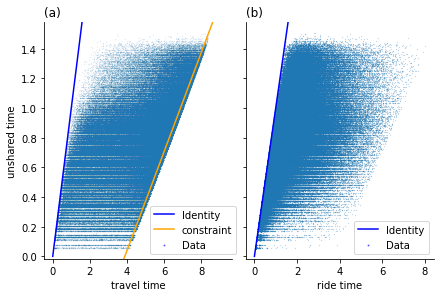

In [194]:
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib import rc

# activate latex text rendering
# rc('text', usetex=True)

fig, (ax, ax2) = plt.subplots(1, 2, constrained_layout=True, sharey=True)
# fig = plt.figure(constrained_layout=True)
# gs = fig.add_gridspec(12, 2)
# ax = fig.add_subplot(gs[:10, 0])
# ax2 = fig.add_subplot(gs[:10, 1])
# cax = fig.add_subplot(gs[11,0])
# cax2 = fig.add_subplot(gs[11,1])

xmin = detour_df["time"].min()
xmax = detour_df["time"].max()
ymin = detour_df["unsharedTime"].min()
ymax = detour_df["unsharedTime"].max()
nx, ny = int((xmax - xmin) / 50), int((ymax - ymin) / 50)
# im = ax.hexbin(detour_df["time"], detour_df["unsharedTime"], gridsize=(nx, ny), cmap='hot_r', extent=(xmin,xmax,ymin,ymax))
# im = ax.hexbin(
#     detour_df["time"],
#     detour_df["unsharedTime"],
#     gridsize=20,
#     cmap="hot_r",
#     extent=(xmin, xmax, ymin, ymax),
#     norm=LogNorm(),
# )
# fig.colorbar(im, ax=ax, location="bottom")
ax.scatter(detour_df["time"], detour_df["unsharedTime"], alpha=0.5, c=u'#1f77b4', s=0.01, zorder=-1)
ax.scatter([], [], alpha=0.5, s=1, c="b", label='Data')
ylims = ax.get_ylim()
ax.plot([0, ymax * 1.1], [0, ymax * 1.1], c="b", label="Identity", zorder=1)
ax.plot([0, xmax*1.1], [-beta/3, (xmax*1.1-beta)/3], c="orange", label="constraint", zorder=1)
print((detour_df["time"]/detour_df["unsharedTime"]).mean())
ax.set_ylim(ylims)

ax.set_xlabel("travel time")
ax.set_ylabel("unshared time")
ax.set_title("(a)", loc="left")
# fig.colorbar(im, cax=cax, orientation='horizontal')
ax.legend(loc="lower right", bbox_to_anchor=[1.05, 0])
ax.set_rasterization_zorder(0)

ride_time = detour_df["time"] - trip_df["waitTime"]
xmin = ride_time.min()
xmax = ride_time.max()
ymin = detour_df["unsharedTime"].min()
ymax = detour_df["unsharedTime"].max()
# print(xmin, xmax, ymin, ymax)
nx, ny = int((xmax - xmin) / 50), int((ymax - ymin) / 10)
# im2 = ax2.hexbin(
#     ride_time,
#     detour_df["unsharedTime"],
#     #     gridsize=(nx, ny),
#     gridsize=20,
#     cmap="hot_r",
#     norm=LogNorm(),
#     #     extent=(xmin, xmax, ymin, ymax),
# )
# fig.colorbar(im2, ax=ax2, location="bottom")
ax2.scatter(ride_time, detour_df["unsharedTime"], s=0.01, zorder=-1)
ax2.scatter([], [], alpha=0.5, s=1, c="b", label='Data', zorder=1)
print((ride_time/detour_df["unsharedTime"]).mean())
# xlim = ax2.get_xlim()
# ax2.plot([-100, xlim[1]], [-100, xlim[1]], c="r", label="Identity")
ax2.plot([0, ymax * 1.1], [0, ymax * 1.1], c="b", label="Identity")
ax2.set_xlabel("ride time")
ax2.set_title("(b)", loc="left")
# ax2.set_ylabel('Unshared ride time (s)')
ax2.legend()
ax2.set_rasterization_zorder(0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# fig.savefig('Figures/TimeDetourComparison.pgf', dpi=300)
plt.show()

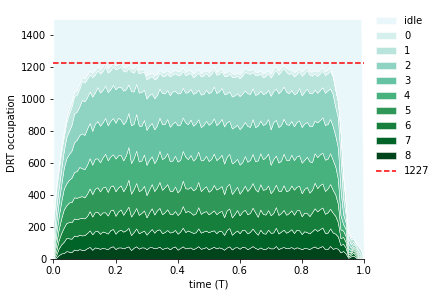

In [198]:
%matplotlib inline
fig, ax = plt.subplots(constrained_layout=True)

labels_w_stay = occ_df.columns.drop("time").to_numpy()[::-1]
labels_wo_stay = [
    item[0] if item != "STAY" else "idle"
    for item in labels_w_stay
]
cmap = plt.get_cmap("BuGn")
time_rescaled = occ_df["time"]/occ_df["time"].max()
stack = ax.stackplot(
    time_rescaled,
    #     occ_df[["4 pax", "3 pax", "2 pax", "1 pax", "0 pax", "STAY"]].T,
    occ_df[labels_w_stay].T,
    labels=labels_wo_stay,
    #     colors=["b", "g", "r", "c", "m", "grey"],
    colors=[cmap(1-x/len(labels_wo_stay)) for x in range(len(labels_wo_stay))],
    linewidth=0.5,
    edgecolor="white",
)

max_needed_fleet_size = round(occ_df.drop(columns=["time", "STAY"]).sum(axis=1).max())

ax.axhline(max_needed_fleet_size, ls="--", c="r", label=max_needed_fleet_size)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[::-1],
    labels=labels[::-1],
    bbox_to_anchor=(1.01, 0, 0.1, 1),
    loc="upper left",
    ncol=1,
    frameon=False
)

ax.set_xlim((0, 1))  # occ_df['time'].max()))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xlabel("time (T)")
ax.set_ylabel("DRT occupation")

# fig.savefig("Figures/DrtOccupancyOneScenario.pgf")

plt.show()

In [195]:
def getAverageTimeSeries(series):
    time_diff = series.index.values[1:] - series.index.values[:-1]
    if len(time_diff) > 0:
        return np.nansum(time_diff * series.values[:-1]) / time_diff.sum()
    else:
        return None

def getPtOccupancy(path):
    #TODO generalize (no 900)
    av_pt_occ, av_pt_occ_sq, n_pt = getPtOccupancies(
        path, 900
    )
    t_av_pt_occ_av = getAverageTimeSeries(av_pt_occ)
    sigma = np.sqrt(n_pt / (n_pt - 1)) * np.sqrt(
        av_pt_occ_sq - av_pt_occ ** 2
    )
    t_av_pt_occ_sigma = getAverageTimeSeries(sigma)
    return t_av_pt_occ_av, t_av_pt_occ_sigma

# print(getPtOccupancy(os.path.join(itpath, "0.occupancyAnalysis.txt")))
pt_occ, pt_occ_std = getPtOccupancy(os.path.join(itpath, "0.occupancyAnalysis.txt"))

In [196]:
print(pt_occ, pt_occ_std)
# Theory values calculated in AnalyzeCarbonFootprint notebook

59.04628865904941 27.724070083162587


In [ ]:
%matplotlib notebook

from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.integrate import quad

mask = (occ_df['time'] > 10000) & (occ_df['time'] < 85000)

mean_equil_occs = occ_df[mask].mean(axis=0).drop(['time','STAY'])
def boltzmann(E, kt, Z):
#     kt=1
    return Z*np.exp(-E/kt)
# display(mean_equil_occs)

#mean_equil_occs.plot(kind='scatter')
occupancies = np.arange(1,9)
occupancies_cont = np.linspace(occupancies[0], occupancies[-1], 1000)
probs = mean_equil_occs[1:]/np.sum(mean_equil_occs[1:])

popt, pcov = curve_fit(boltzmann, occupancies, probs)
# sol = least_squares(lambda kt: (boltzmann(occupancies, kt)-probs)**2, popt, verbose=1)
# print(sol)
print(*popt)
# popt[0] = 1.6

plt.scatter(occupancies, probs)
# plt.figure()
# Z,_ = quad(lambda x: boltzmann(x,*popt), 1,8) 

# plt.plot(occupancies, boltzmann(occupancies, *popt)/np.sum(boltzmann(occupancies, *popt)))
plt.plot(occupancies_cont, boltzmann(occupancies_cont, *popt), ls='--')

plt.show()